In [2]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS, upsample, generate_rand_tex
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)
from utils.spot import reset_scene, TEX_KEY

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

In [3]:
def plot(
    images_bm, tex_bm, size_factor=3
):
    if not isinstance(images_bm, list):
        images_bm = [images_bm]
        tex_bm = [tex_bm]
    fig, ax = plt.subplots(
        ncols=2,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, (img, tex) in enumerate(
        zip(images_bm, tex_bm)
    ):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 1].imshow(tex, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    ax[0, 1].set_title("Texture", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

In [11]:
CAMERA_ROT = [
    {"axis":[1, 0, 0], "angle":0},
    {"axis":[1, 0, 0], "angle":120},
    {"axis":[1, 0, 0], "angle":-120},
    {"axis":[0, 1, 0], "angle":120},
    {"axis":[0, 1, 0], "angle":-120},
    {"axis":[0, 0, 1], "angle":120},
    {"axis":[0, 0, 1], "angle":-120},
]

# Reference scenes rendering

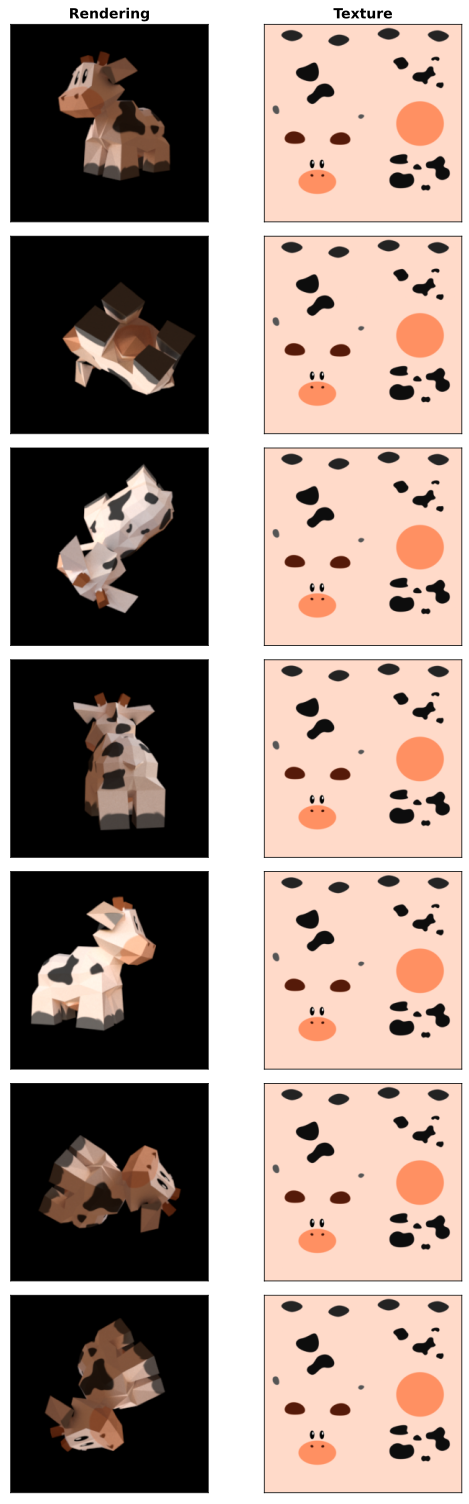

In [13]:
spp_ref = 1024

scene_ref = reset_scene()
params_ref = mi.traverse(scene_ref)
params_tex_ref = params_ref[TEX_KEY]
params_tex_ref_bm = unidim_to_bm(params_tex_ref)

image_ref = []
image_ref_bm = []

# Render reference images
for i, rot in enumerate(CAMERA_ROT):
    scene = reset_scene()
    params = mi.traverse(scene)
    params['sensor.to_world'] = mi.Transform4f.rotate(**rot) @ params['sensor.to_world']
    image_ref.append(mi.render(scene, seed=i, spp=spp_ref))
    image_ref_bm.append(image_to_bm(image_ref[i]))

# Plot
plot(image_ref_bm, [params_tex_ref_bm] * len(image_ref_bm))

In [33]:
spp_primal = 128
spp = spp_primal
spp_grad = 32

{'Relative L1': 0.0859060101211071, 'MSE': 0.0006301166431512684}


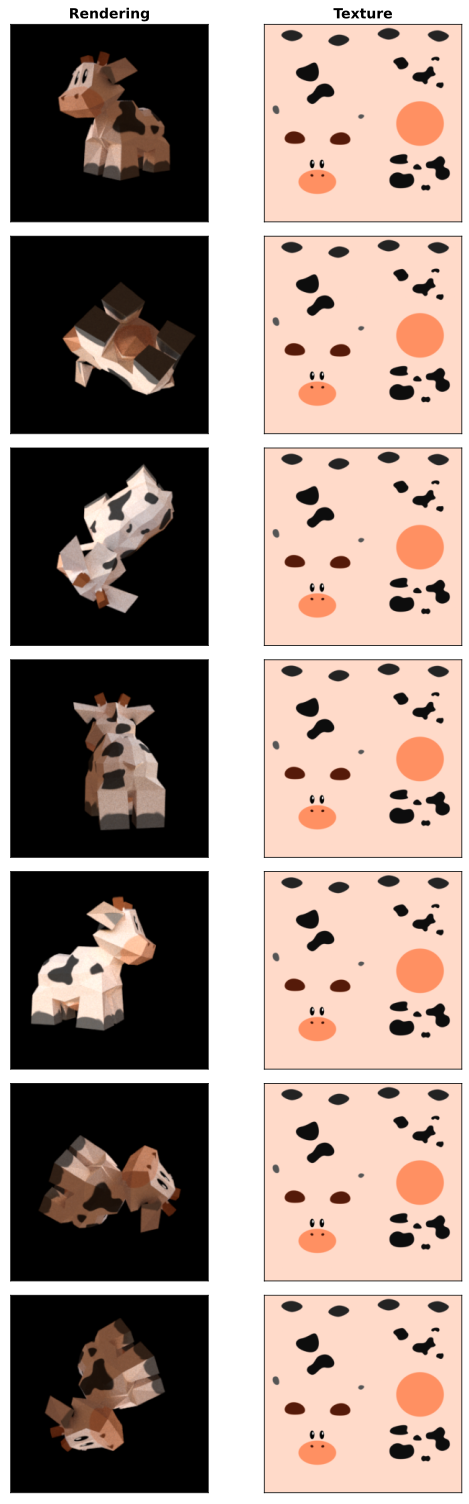

In [34]:
# get reference losses
ref_loss = {k: 0.0 for k in LOSS_FNS}
images = []
for i, rot in enumerate(CAMERA_ROT):
    scene = reset_scene()
    params = mi.traverse(scene)
    params['sensor.to_world'] = mi.Transform4f.rotate(**rot) @ params['sensor.to_world']
    image = mi.render(scene, mi.traverse(scene), seed=i, spp=spp_primal)
    images.append(image)
    for k in LOSS_FNS:
        ref_loss[k] += to_float(LOSS_FNS[k](image, image_ref[i]))
print(ref_loss)
plot([image_to_bm(image) for image in images], [params_tex_ref_bm] * len(images))

In [35]:
def run_opt_set_init(
    init_values,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=mse,
    n_iterations=10,
    spp_primal=16,
    spp_grad=4,
):
    # Optimization parameters
    optimizer_name = optimizer_name.lower().strip()

    losses = []
    images_init = []
    images_bm_init = []
    images_end = []
    images_bm_end = []
    tex_bm_init = []
    tex_bm_end = []
    params_end = []

    nb_opt_samples = len(init_values)

    for (opt_sample, initial_values) in enumerate(init_values):
        scene = reset_scene()
        params = mi.traverse(scene)
        params[TEX_KEY] = initial_values
        params.update()

        if optimizer_name == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[TEX_KEY] = params[TEX_KEY]
        params.update(opt)

        losses.append([])
        for it in range(1,n_iterations+1):
            total_loss = 0.0
            for i, rot in enumerate(CAMERA_ROT):
                params['sensor.to_world'] = mi.Transform4f.rotate(**rot) @ params_ref['sensor.to_world']
                params.update()

                image = mi.render(
                    scene,
                    params,
                    seed=opt_sample * n_iterations + it + i * nb_opt_samples * n_iterations,
                    spp=spp_primal,
                    spp_grad=spp_grad,
                )

                if it == 1:
                    if i == 0:
                        images_init.append([])
                        images_bm_init.append([])
                        tex_bm_init.append(unidim_to_bm(params[TEX_KEY]))
                    images_init[opt_sample].append(image)
                    images_bm_init[opt_sample].append(image_to_bm(image))
                
                # Compute loss
                loss = loss_fn(image, image_ref[i])
                total_loss += to_float(loss)

                # Backpropagate
                dr.backward(loss)

                # Optimizer: take a gradient step
                opt.step()
                opt[TEX_KEY] = dr.clamp(opt[TEX_KEY], 1e-2, 1.0)

                # Optimizer: Update the scene parameters
                params.update(opt)

                if it == n_iterations:
                    if i == 0:
                        images_end.append([])
                        images_bm_end.append([])
                    images_end[opt_sample].append(image)
                    images_bm_end[opt_sample].append(image_to_bm(image))
                    if i == len(CAMERA_ROT) - 1:
                        tex_bm_end.append(unidim_to_bm(params[TEX_KEY]))
                        params_end.append(params[TEX_KEY])

            print(
                f"[Sample {opt_sample+1}/{nb_opt_samples}]  Iteration {it:03d}: loss={total_loss:.5f}",
                end="\r",
            )
            losses[opt_sample].append(total_loss)
        print()
        
    return {
        "losses": losses,
        "images_init": images_init,
        "images_bm_init": images_bm_init,
        "images_end": images_end,
        "images_bm_end": images_bm_end,
        "tex_bm_init": tex_bm_init,
        "tex_bm_end": tex_bm_end,
        "params_end": params_end,
    }

# Run optimization

In [36]:
values = [generate_rand_tex(init_res=1024, opt_res=1024, n_channels=3, seed=i) for i in range(1)]
res = run_opt_set_init(values, optimizer_name="adam", lr=1e-2, loss_fn=mse, n_iterations=100, spp_primal=spp_primal, spp_grad=spp_grad)

[Sample 1/1]  Iteration 100: loss=0.00083


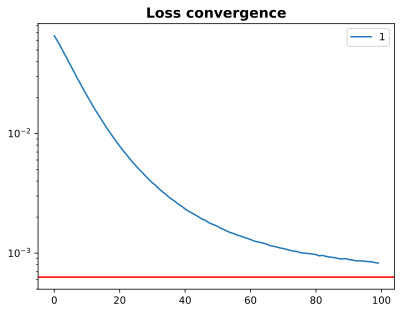

In [37]:
plot_losses(res["losses"], baseline=ref_loss["MSE"])

In [38]:
plot(res["images_bm_init"][0], res["tex_bm_init"]*len(res["images_bm_init"][0]), size_factor=3)

In [39]:
plot(res["images_bm_end"][0], res["tex_bm_end"]*len(res["images_bm_end"][0]), size_factor=3)

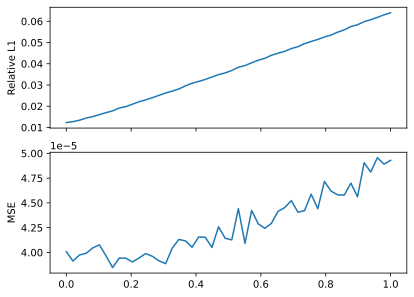

In [40]:
params_1 = {TEX_KEY: params_tex_ref}
params_2 = {TEX_KEY: res["params_end"][0]}
plot_loss_linear_interp_1d(image_ref[0], params_1, params_2, reset_scene_func=reset_scene, spp=128)